In [106]:
import matplotlib.pyplot as plt
from math import exp, sin, pi
from numpy import linspace

In [107]:
class StabilityException(Exception):
    def __init__(self, tau, h):
        self.tau = tau
        self.h = h
        super().__init__(self._error_message())

    def _error_message(self):
        return f"Stability condition violated: tau / (h * h) > 0.5 (tau={self.tau}, h={self.h})"

In [108]:
def print_grid(u, K, n):
    for i in range(K):
        string = ""
        for j in range(n):
            string += f"{u[i][j]:0.5f} "
        print(string)

In [109]:
def tk(k, tau):
    return k * tau

def xi(L, i, h):
    return L + i * h

In [110]:
def f(t, x):
    return 0.5 * exp(-0.5 * t) * sin(x)

In [111]:
def Phi_L(t):
    return exp(-0.5 * t)

def Phi_R(t):
    return -exp(-0.5 * t)

def Psi(x):
    return sin(x)

In [112]:
def analytic(t, x):
    return exp(-0.5 * t) * sin(x)

In [113]:
def explicit(n, L, R, K, T, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = tau / (h * h)
    if sigma > 0.5:
        raise StabilityException(tau, h)
    for i in range(n + 1):
        u[0][i] = Psi(xi(L, i, h))
    for k in range(1, K + 1):
        for i in range(1, n):
            u[k][i] = (
                sigma * u[k - 1][i - 1] +
                (1 - 2 * sigma) * u[k - 1][i] +
                sigma * u[k - 1][i + 1] +
                f(tk(k - 1, tau), xi(L, i, h)) * tau
            )
        if approx == 1:
            u[k][0] = u[k][1] - Phi_L(tk(k, tau)) * h
            u[k][-1] = u[k][-2] + Phi_R(tk(k, tau)) * h
        elif approx == 2:
            u[k][0] = (-1 / 3) * (2 * h * Phi_L(tk(k, tau)) + u[k][2] - 4 * u[k][1])
            u[k][-1] = (1 / 3) * (2 * h * Phi_R(tk(k, tau)) + 4 * u[k][-2] - u[k][-3])
        elif approx == 3:
            g = (h * h) / (2 * tau)
            u[k][0] = (
                (1 / (1 + g)) *
                (u[k][1] - Phi_L(tk(k, tau)) * h + g * u[k - 1][0] + g * tau * f(tk(k, tau), xi(L, 0, h)))
            )
            u[k][-1] = (
                (1 / (1 + g)) *
                (u[k][-2] + Phi_R(tk(k, tau)) * h + g * u[k - 1][-1] + g * tau * f(tk(k, tau), xi(L, n, h)))
            )
    return u

In [114]:
def TMA(a, b, c, d):
    n = len(d)
    P = [0 for _ in range(n)]
    Q = [0 for _ in range(n)]
    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]
    for i in range(1, n - 1):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[-1] = 0
    Q[-1] = (d[n - 1] - a[n - 1] * Q[n - 2]) / (b[n - 1] + a[n - 1] * P[n - 2])
    x = [0 for _ in range(n)]
    x[-1] = Q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]
    return x

In [115]:
def implicit(n, L, R, K, T, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = tau / (h * h)
    a = [0.0 for _ in range(n + 1)]
    b = [0.0 for _ in range(n + 1)]
    c = [0.0 for _ in range(n + 1)]
    d = [0.0 for _ in range(n + 1)]
    for i in range(n + 1):
        u[0][i] = Psi(xi(L, i, h))
    for k in range(K):
        for i in range(1, n):
            a[i] = sigma
            b[i] = -1 - 2 * sigma
            c[i] = sigma
            d[i] = -tau * f(tk(k + 1, tau), xi(L, i, h)) - u[k][i]
        if approx == 1:
            a[0] = 0
            b[0] = -1
            c[0] = 1
            d[0] = Phi_L(tk(k + 1, tau)) * h
            a[-1] = -1
            b[-1] = 1
            c[-1] = 0
            d[-1] = Phi_R(tk(k + 1, tau)) * h
        elif approx == 2:
            a[0] = 0
            b[0] = -2
            c[0] = 4 + (-1 - 2 * sigma) / sigma
            d[0] = (
                Phi_L(tk(k + 1, tau)) * 2 * h + 
                (tau / sigma) * f(tk(k + 1, tau), xi(L, 1, h)) -
                u[k][1] / sigma 
            )
            a[-1] = -4 + (1 + 2 * sigma) / sigma
            b[-1] = 2
            c[-1] = 0
            d[-1] = (
                Phi_R(tk(k + 1, tau)) * 2 * h -
                (tau / sigma) * f(tk(k + 1, tau), xi(L, n - 1, h)) +
                u[k][-2] / sigma
            )
        elif approx == 3:
            g = (h * h) / (2 * tau)
            a[0] = 0
            b[0] = 1 + g
            c[0] = -1
            d[0] = (
                g * u[k][0] + 
                g * tau * f(tk(k + 1, tau), xi(L, 0, h)) -
                h * Phi_L(tk(k + 1, tau))
            )
            a[-1] = 1
            b[-1] = -1 - g
            d[-1] = (
                -g * u[k][-1] -
                g * tau * f(tk(k + 1, tau), xi(L, n, h)) -
                h * Phi_R(tk(k + 1, tau))
            )
        solve = TMA(a, b, c, d)
        for i in range(n):
            u[k + 1][i] = solve[i]
    return u

In [116]:
def crank_nicolson(n, L, R, K, T, theta=0.5, approx=1):
    u = [[0.0 for _ in range(n + 1)] for _ in range(K + 1)]
    tau = T / K
    h = (R - L) / n
    sigma = tau / (h * h)
    a = [0.0 for _ in range(n + 1)]
    b = [0.0 for _ in range(n + 1)]
    c = [0.0 for _ in range(n + 1)]
    d = [0.0 for _ in range(n + 1)]
    for i in range(n + 1):
        u[0][i] = Psi(xi(L, i, h))
    for k in range(K):
        for i in range(1, n):
            a[i] = sigma * theta
            b[i] = -1 - 2 * sigma * theta
            c[i] = sigma * theta
            d[i] = (
                (2 * (1 - theta) * sigma - 1) * u[k][i] -
                theta * tau * f(tk(k + 1, tau), xi(L, i, h)) -
                (1 - theta) * sigma * u[k][i - 1] -
                (1 - theta) * sigma * u[k][i + 1] -
                (1 - theta) * tau * f(tk(k, tau), xi(L, i, h))
            )
        if approx == 1:
            a[0] = 0
            b[0] = -1
            c[0] = 1
            d[0] = Phi_L(tk(k + 1, tau)) * h
            a[-1] = -1
            b[-1] = 1
            c[-1] = 0
            d[-1] = Phi_R(tk(k + 1, tau)) * h
        elif approx == 2:
            a[0] = 0
            b[0] = -2
            c[0] = 4 + (-1 - 2 * sigma) / sigma
            d[0] = (
                Phi_L(tk(k + 1, tau)) * 2 * h + 
                (tau / sigma) * f(tk(k + 1, tau), xi(L, 1, h)) -
                u[k][1] / sigma 
            )
            a[-1] = -4 + (1 + 2 * sigma) / sigma
            b[-1] = 2
            c[-1] = 0
            d[-1] = (
                Phi_R(tk(k + 1, tau)) * 2 * h -
                (tau / sigma) * f(tk(k + 1, tau), xi(L, n - 1, h)) +
                u[k][-2] / sigma
            )
        elif approx == 3:
            g = (h * h) / (2 * tau)
            a[0] = 0
            b[0] = 1 + g
            c[0] = -1
            d[0] = (
                g * u[k][0] + 
                g * tau * f(tk(k + 1, tau), xi(L, 0, h)) -
                h * Phi_L(tk(k + 1, tau))
            )
            a[-1] = 1
            b[-1] = -1 - g
            d[-1] = (
                -g * u[k][-1] -
                g * tau * f(tk(k + 1, tau), xi(L, n, h)) -
                h * Phi_R(tk(k + 1, tau))
            )
        solve = TMA(a, b, c, d)
        for i in range(n):
            u[k + 1][i] = solve[i]
    return u

In [117]:
L = 0
R = pi

T = 10
n = 100
K = 50000

u_explicit_1 = explicit(n, L, R, K, T, approx=1)
u_explicit_2 = explicit(n, L, R, K, T, approx=2)
u_explicit_3 = explicit(n, L, R, K, T, approx=3)
u_implicit_1 = implicit(n, L, R, K, T, approx=1)
u_implicit_2 = implicit(n, L, R, K, T, approx=2)
u_implicit_3 = implicit(n, L, R, K, T, approx=3)
u_crank_nicolson_1 = crank_nicolson(n, L, R, K, T, approx=1)
u_crank_nicolson_2 = crank_nicolson(n, L, R, K, T, approx=2)
u_crank_nicolson_3 = crank_nicolson(n, L, R, K, T, approx=3)

In [118]:
tau = T / K
h = (R - L) / n

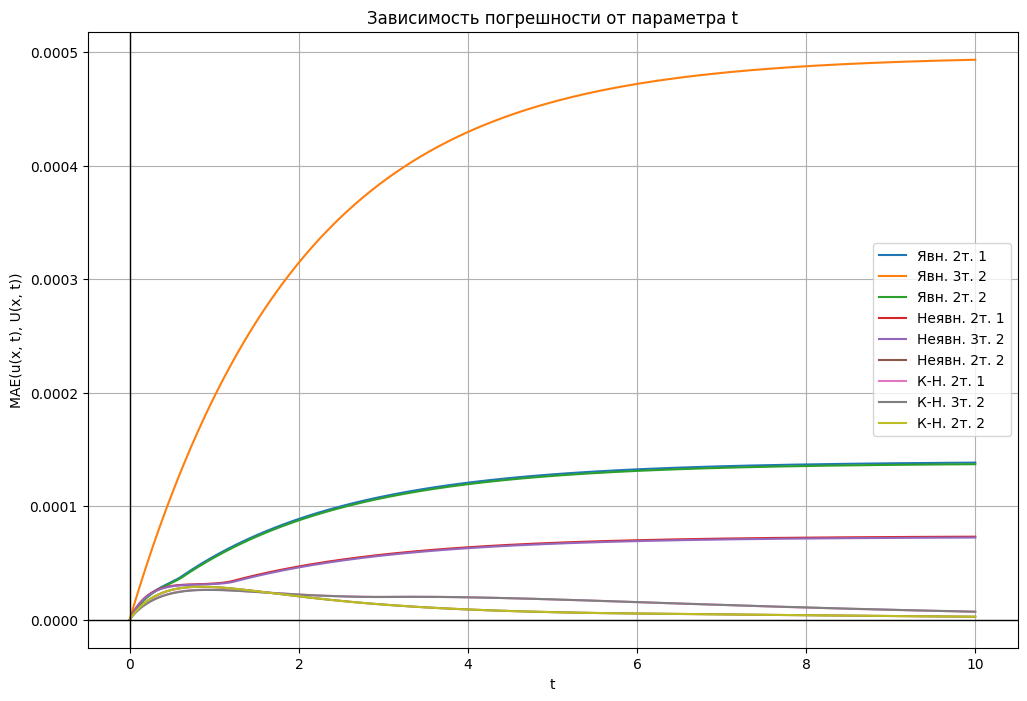

In [119]:
time = linspace(0, T, K + 1)
mae_u_explicit_1 = [0 for _ in range(K + 1)]
mae_u_explicit_2 = [0 for _ in range(K + 1)]
mae_u_explicit_3 = [0 for _ in range(K + 1)]
mae_u_implicit_1 = [0 for _ in range(K + 1)]
mae_u_implicit_2 = [0 for _ in range(K + 1)]
mae_u_implicit_3 = [0 for _ in range(K + 1)]
mae_u_implicit_1 = [0 for _ in range(K + 1)]
mae_u_crank_nicolson_1 = [0 for _ in range(K + 1)]
mae_u_crank_nicolson_2 = [0 for _ in range(K + 1)]
mae_u_crank_nicolson_3 = [0 for _ in range(K + 1)]
for k in range(K + 1):
    for i in range(n + 1):
        mae_u_explicit_1[k] += abs(u_explicit_1[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_explicit_2[k] += abs(u_explicit_2[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_explicit_3[k] += abs(u_explicit_3[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_implicit_1[k] += abs(u_implicit_1[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_implicit_2[k] += abs(u_implicit_2[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_implicit_3[k] += abs(u_implicit_3[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_crank_nicolson_1[k] += abs(u_crank_nicolson_1[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_crank_nicolson_2[k] += abs(u_crank_nicolson_2[k][i] - analytic(tk(k, tau), xi(L, i, h)))
        mae_u_crank_nicolson_3[k] += abs(u_implicit_3[k][i] - analytic(tk(k, tau), xi(L, i, h)))
    mae_u_explicit_1[k] /= n
    mae_u_explicit_2[k] /= n
    mae_u_explicit_3[k] /= n
    mae_u_implicit_1[k] /= n
    mae_u_implicit_2[k] /= n
    mae_u_implicit_3[k] /= n
    mae_u_crank_nicolson_1[k] /= n
    mae_u_crank_nicolson_2[k] /= n
    mae_u_crank_nicolson_3[k] /= n
plt.figure(figsize=(12, 8))
plt.plot(time, mae_u_explicit_1, label="Явн. 2т. 1")
plt.plot(time, mae_u_explicit_2, label="Явн. 3т. 2")
plt.plot(time, mae_u_explicit_3, label="Явн. 2т. 2")
plt.plot(time, mae_u_implicit_1, label="Неявн. 2т. 1")
plt.plot(time, mae_u_implicit_2, label="Неявн. 3т. 2")
plt.plot(time, mae_u_implicit_3, label="Неявн. 2т. 2")
plt.plot(time, mae_u_crank_nicolson_1, label="К-Н. 2т. 1")
plt.plot(time, mae_u_crank_nicolson_2, label="К-Н. 3т. 2")
plt.plot(time, mae_u_crank_nicolson_3, label="К-Н. 2т. 2")
plt.xlabel('t')
plt.ylabel('MAE(u(x, t), U(x, t))')
plt.title('Зависимость погрешности от параметра t')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

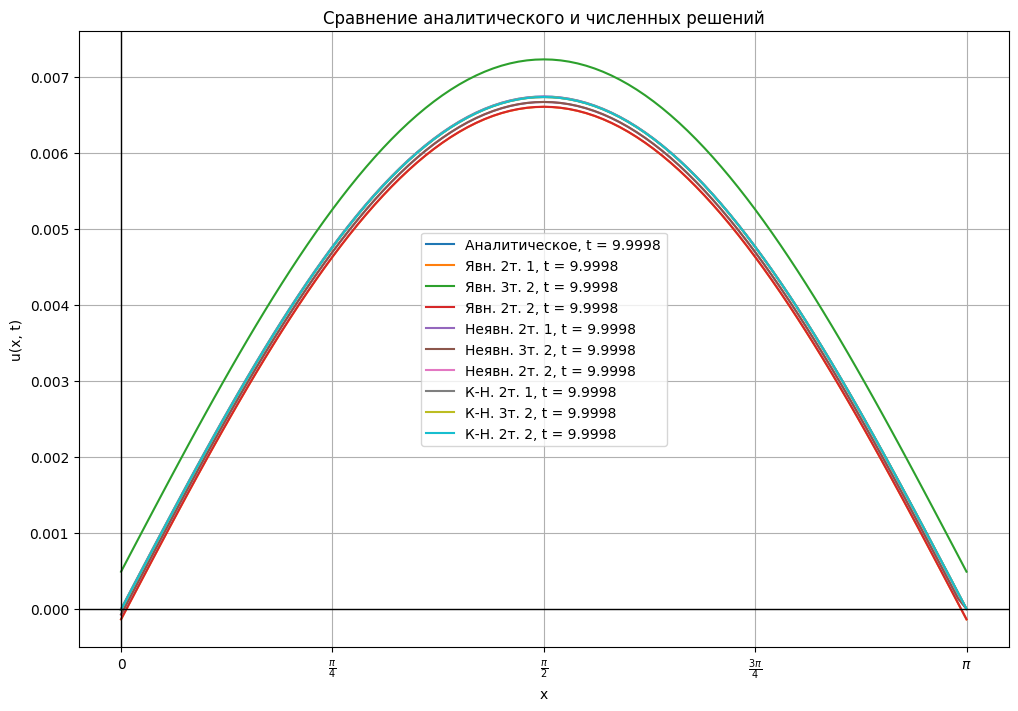

In [126]:
# time_index = int(input())
time_index = 49999
x = linspace(L, R, n + 1)
plt.figure(figsize=(12, 8))
current_time = tk(time_index, tau)
u_analytic_values = [analytic(current_time, xi(L, i, h)) for i in range(n + 1)]
u_explicit_1_values = [u_explicit_1[time_index][i] for i in range(n + 1)]
u_explicit_2_values = [u_explicit_2[time_index][i] for i in range(n + 1)]
u_explicit_3_values = [u_explicit_3[time_index][i] for i in range(n + 1)]
u_implicit_1_values = [u_implicit_1[time_index][i] for i in range(n + 1)]
u_implicit_2_values = [u_implicit_2[time_index][i] for i in range(n + 1)]
u_implicit_3_values = [u_implicit_3[time_index][i] for i in range(n + 1)]
u_crank_nicolson_1_values = [u_crank_nicolson_1[time_index][i] for i in range(n + 1)]
u_crank_nicolson_2_values = [u_crank_nicolson_2[time_index][i] for i in range(n + 1)]
u_crank_nicolson_3_values = [u_crank_nicolson_3[time_index][i] for i in range(n + 1)]
plt.plot(x, u_analytic_values, label=f'Аналитическое, t = {current_time}')
plt.plot(x, u_explicit_1_values, label=f'Явн. 2т. 1, t = {current_time}')
plt.plot(x, u_explicit_2_values, label=f'Явн. 3т. 2, t = {current_time}')
plt.plot(x, u_explicit_3_values, label=f'Явн. 2т. 2, t = {current_time}')
plt.plot(x, u_implicit_1_values, label=f'Неявн. 2т. 1, t = {current_time}')
plt.plot(x, u_implicit_2_values, label=f'Неявн. 3т. 2, t = {current_time}')
plt.plot(x, u_implicit_3_values, label=f'Неявн. 2т. 2, t = {current_time}')
plt.plot(x, u_crank_nicolson_1_values, label=f'К-Н. 2т. 1, t = {current_time}')
plt.plot(x, u_crank_nicolson_2_values, label=f'К-Н. 3т. 2, t = {current_time}')
plt.plot(x, u_crank_nicolson_3_values, label=f'К-Н. 2т. 2, t = {current_time}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Сравнение аналитического и численных решений')
plt.xticks(ticks=[0, pi/4, pi/2, 3*pi/4, pi], 
           labels=['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'])
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()